### Import libraries as needed

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler, Dataset
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import copy

### Define helper functions

In [2]:
###########################################################################################

# Function to plot the training and validation accuracy and loss --------------------------
def plot_history(history):
    fig, axs = plt.subplots(2)

    # Create accuracy subplot
    axs[0].plot([acc.cpu().numpy() for acc in history['train_acc']], label="train accuracy")
    axs[0].plot([acc.cpu().numpy() for acc in history['val_acc']], label="validation accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy Evaluation")

    # Create error subplot
    axs[1].plot(history['train_loss'], label="train error")
    axs[1].plot(history['val_loss'], label="validation error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error Evaluation")

    plt.show()

###########################################################################################

# Function to visualize some images before you train --------------------------------------
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp, cmap='gray')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

############################################################################################

# Function to visualize sample count before split ------------------------------------------
def plot_class_distribution(counts, title):
    # Directly use counts.keys() if they are already class names
    labels = list(counts.keys())
    values = list(counts.values())

    plt.figure(figsize=(10,5))
    plt.bar(labels, values)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()


############################################################################################

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues');
    plt.ylabel('Actual Label');
    plt.xlabel('Predicted Label');
    plt.title('Confusion Matrix', size=15);
    plt.show()

############################################################################################

# Function for classification report for perfomance metrics
from sklearn import preprocessing
def calculate_metrics(y_true, y_pred):
    le = preprocessing.LabelEncoder()
    le.fit(y_true)
    class_names = [str(cls) for cls in le.classes_]
    print(classification_report(y_true, y_pred, target_names=class_names))

############################################################################################


### Define function to **train** the model

In [5]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=25, patience=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Initialize the history
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    # Initialize variables for early stopping
    num_epochs_no_improvement = 0
    best_loss = float('inf')

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Validation']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # if phase == 'Train':
            #     scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Validation':
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(epoch_loss)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), f'cnn_6layer_noNorm_balanced.pth')
                    num_epochs_no_improvement = 0
                else:
                    num_epochs_no_improvement += 1

            # Save the loss and accuracy in history
            if phase == 'Train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)

        print()

        # Early stopping
        if num_epochs_no_improvement >= patience:
            print('No improvement in validation accuracy for {} epochs, stopping early.'.format(patience))
            break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


### Load data, setup dataloaders, and visualize sample counts

Add balancing to data set using Data Augmentation and oversampling classes

In [6]:
# Custom Dataset for Balancing Classes with Augmentation
class BalancedDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform
        self.indices = self._balance_classes(dataset)

    def _balance_classes(self, dataset):
        class_counts = dict(Counter(dataset.targets))
        max_count = max(class_counts.values())
        class_indices = [np.where(np.array(dataset.targets) == class_id)[0] for class_id in class_counts]
        balanced_indices = [np.random.choice(indices, max_count, replace=True).tolist() for indices in class_indices]
        return [idx for indices in balanced_indices for idx in indices]

    def __getitem__(self, index):
        img, label = self.dataset[self.indices[index]]
        img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.indices)

In [7]:
# Define your transformations
# Transformation with augmentation for training data
balanced_train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# Transformation without augmentation for validation and testing data
val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])


train_dir = 'C:/Users/Anish Patel/Desktop/ENSF645 Final Project/Dataset/train'
test_dir = 'C:/Users/Anish Patel/Desktop/ENSF645 Final Project/Dataset/test'

# Load the datasets
train_data = datasets.ImageFolder(train_dir)
test_data = datasets.ImageFolder(test_dir, transform=val_test_transform)

# Applying the BalancedDataset wrapper to the training dataset
balanced_train_data = BalancedDataset(train_data, balanced_train_transform)

# Get the class names
class_names_train = test_data.classes
class_names_test = test_data.classes

# Create a dictionary mapping indices to class names
idx_to_class_train = {i: class_name for i, class_name in enumerate(class_names_train)}
idx_to_class_test = {i: class_name for i, class_name in enumerate(class_names_test)}

# Count labels in the original dataset for train and test
test_counts = Counter(test_data.targets)
balanced_train_counts = Counter()

# Iterate through the balanced indices to count each label
for idx in balanced_train_data.indices:
    # Get the label from the original dataset using the balanced index
    label = balanced_train_data.dataset.targets[idx]
    balanced_train_counts[label] += 1

# Map the counted indices back to class names using idx_to_class_train
balanced_train_counts_mapped = {idx_to_class_train[idx]: count for idx, count in balanced_train_counts.items()}

# Print the counts for each class
print("Balanced Train Counts:", balanced_train_counts_mapped)
print("Test Counts:", {idx_to_class_test[i]: count for i, count in test_counts.items()})

Balanced Train Counts: {'angry': 7215, 'fear': 7215, 'happy': 7215, 'sad': 7215, 'surprise': 7215}
Test Counts: {'angry': 958, 'fear': 1024, 'happy': 1774, 'sad': 1247, 'surprise': 831}


In [8]:
print(train_data.classes)

['angry', 'fear', 'happy', 'sad', 'surprise']


In [9]:
# Get the indices of the samples in the validation and test sets
test_indices = [i for i, (img_path, _) in enumerate(test_data.imgs) if 'Private' in img_path]
valid_indices = [i for i, (img_path, _) in enumerate(test_data.imgs) if 'Private' not in img_path]

# Create subset datasets
validation_data = torch.utils.data.Subset(test_data, valid_indices)
test_data = torch.utils.data.Subset(test_data, test_indices)

# Create data loaders
batch_size = 32
num_workers = 2
train_loader = DataLoader(balanced_train_data, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

dataloaders = {
    'Train': train_loader,
    'Validation': validation_loader,
    'Test': test_loader
}

print("Length of Train Loader: ", len(dataloaders['Train']))
print("Length of Validation Loader: ", len(dataloaders['Validation']))

Length of Train Loader:  564
Length of Validation Loader:  92


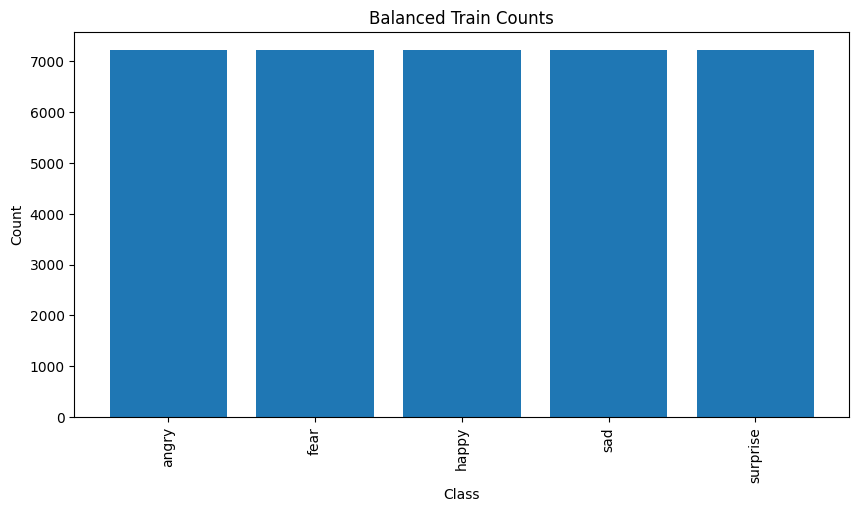

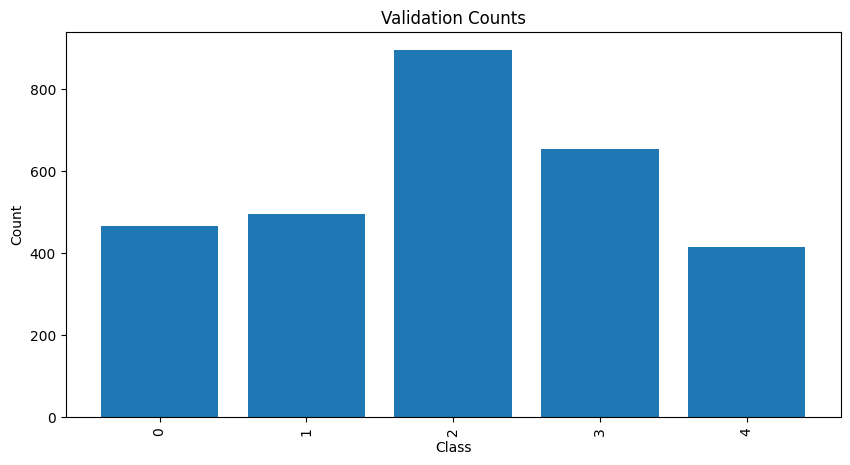

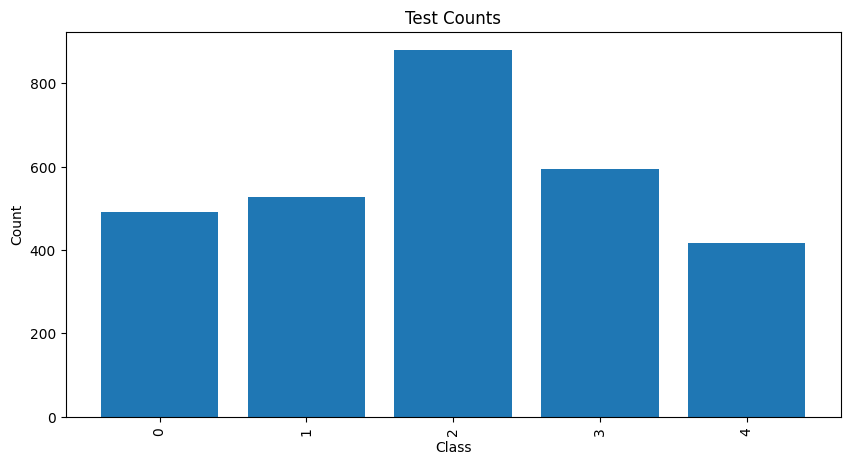

In [10]:
# Get the class names
class_names = train_data.classes

# Create a dictionary mapping indices to class names
idx_to_class = {i: class_name for i, class_name in enumerate(class_names)}

# Use balanced_train_counts_mapped for balanced train counts
balanced_train_counts_mapped = {idx_to_class[idx]: count for idx, count in balanced_train_counts.items()}

# Count labels in the subsets
valid_counts = Counter(test_data.dataset.targets[i] for i in valid_indices)
test_counts = Counter(test_data.dataset.targets[i] for i in test_indices)

# Plot
plot_class_distribution(balanced_train_counts_mapped, 'Balanced Train Counts')
plot_class_distribution(valid_counts, 'Validation Counts')
plot_class_distribution(test_counts, 'Test Counts')

####Data is balanced for train set now

### Visualize some sample from the training set before training

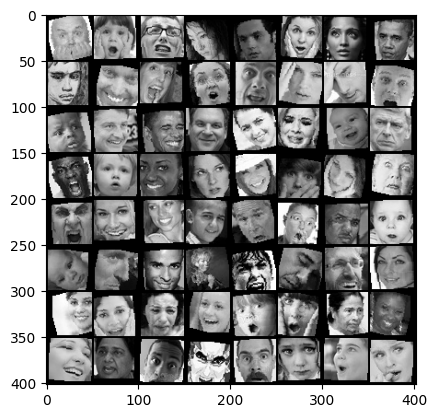

In [11]:
# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out)

### Define a baseline CNN model

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class SixLayerCNN(nn.Module):
    def __init__(self):
        super(SixLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv2 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.25)

        self.conv4 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(1024)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.dropout4 = nn.Dropout(0.25)

        self.conv5 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(1024)
        self.pool5 = nn.MaxPool2d(2, 2)
        self.dropout5 = nn.Dropout(0.25)

        self.conv6 = nn.Conv2d(1024, 2048, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(2048)
        # Removed the last max pooling operation
        self.dropout6 = nn.Dropout(0.25)

        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, 5)  # Changed the output size to 5

    def forward(self, x):
        x = self.dropout1(self.pool1(F.relu(self.bn1(self.conv1(x)))))
        x = self.dropout2(self.pool2(F.relu(self.bn2(self.conv2(x)))))
        x = self.dropout3(self.pool3(F.relu(self.bn3(self.conv3(x)))))
        x = self.dropout4(self.pool4(F.relu(self.bn4(self.conv4(x)))))
        x = self.dropout5(self.pool5(F.relu(self.bn5(self.conv5(x)))))
        x = self.dropout6(F.relu(self.bn6(self.conv6(x))))  # Removed the last max pooling operation
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [13]:
# Assuming that your model is defined and moved to the correct device
model = SixLayerCNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
  print("using gpu")
else:
  print("using cpu")

model = model.to(device)

# Print the summary
summary(model, input_size=(1, 48, 48))

using gpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 48, 48]           1,280
       BatchNorm2d-2          [-1, 128, 48, 48]             256
         MaxPool2d-3          [-1, 128, 24, 24]               0
           Dropout-4          [-1, 128, 24, 24]               0
            Conv2d-5          [-1, 256, 24, 24]         295,168
       BatchNorm2d-6          [-1, 256, 24, 24]             512
         MaxPool2d-7          [-1, 256, 12, 12]               0
           Dropout-8          [-1, 256, 12, 12]               0
            Conv2d-9          [-1, 512, 12, 12]       1,180,160
      BatchNorm2d-10          [-1, 512, 12, 12]           1,024
        MaxPool2d-11            [-1, 512, 6, 6]               0
          Dropout-12            [-1, 512, 6, 6]               0
           Conv2d-13           [-1, 1024, 6, 6]       4,719,616
      BatchNorm2d-14         

### Send model to gpu and define loss function, step optimizer, learning rate scheduler

In [14]:
# Define the criterion
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

### Train the model

In [16]:
model, history = train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=60)
# model = train_model(model, criterion, optimizer, dataloaders, num_epochs=25)

Epoch 0/59
----------


Train Loss: 1.5067 Acc: 0.3502
Validation Loss: 1.3352 Acc: 0.4662

Epoch 1/59
----------
Train Loss: 1.2356 Acc: 0.4918
Validation Loss: 1.0289 Acc: 0.5796

Epoch 2/59
----------
Train Loss: 1.1125 Acc: 0.5444
Validation Loss: 1.1331 Acc: 0.5458

Epoch 3/59
----------
Train Loss: 1.0536 Acc: 0.5722
Validation Loss: 1.0103 Acc: 0.6114

Epoch 4/59
----------
Train Loss: 1.0049 Acc: 0.5928
Validation Loss: 0.9128 Acc: 0.6374

Epoch 5/59
----------
Train Loss: 0.9740 Acc: 0.6078
Validation Loss: 0.9556 Acc: 0.6285

Epoch 6/59
----------
Train Loss: 0.9415 Acc: 0.6201
Validation Loss: 0.9342 Acc: 0.6497

Epoch 7/59
----------
Train Loss: 0.9149 Acc: 0.6334
Validation Loss: 0.9257 Acc: 0.6384

Epoch 8/59
----------
Train Loss: 0.8911 Acc: 0.6447
Validation Loss: 0.8400 Acc: 0.6801

Epoch 9/59
----------
Train Loss: 0.8704 Acc: 0.6501
Validation Loss: 0.8121 Acc: 0.6815

Epoch 10/59
----------
Train Loss: 0.8404 Acc: 0.6644
Validation Loss: 0.8266 Acc: 0.6794

Epoch 11/59
----------
Train Lo

### Plot the loss and accuracy values during training for the train and validation sets

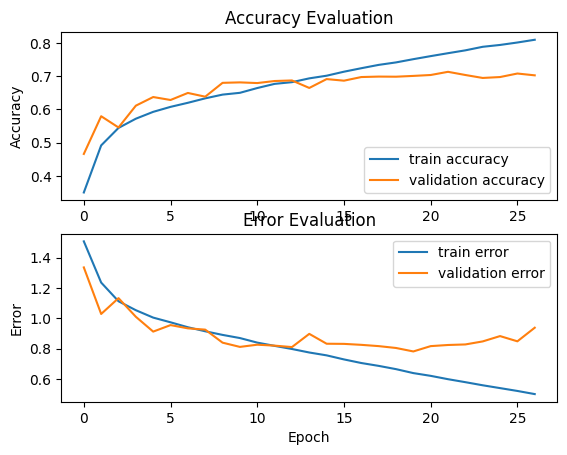

In [20]:
# Plot the history
plot_history(history)

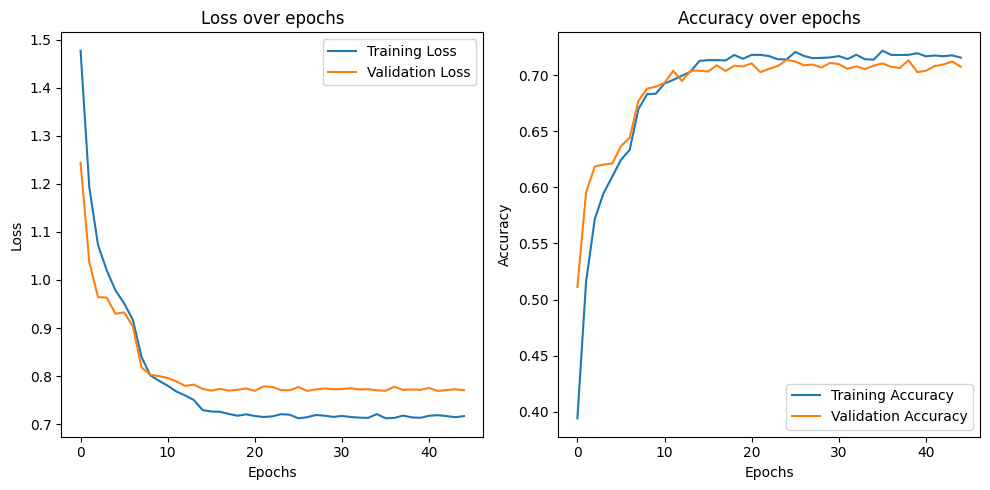

In [18]:
import matplotlib.pyplot as plt

# Define the values for each epoch
train_loss = [1.4770, 1.1934, 1.0729, 1.0202, 0.9785, 0.9513, 0.9170, 0.8395, 0.8015, 0.7902, 0.7800, 0.7679, 0.7597, 0.7502, 0.7293, 0.7263, 0.7257, 0.7213, 0.7175, 0.7204, 0.7170, 0.7149, 0.7162, 0.7208, 0.7196, 0.7121, 0.7145, 0.7191, 0.7176, 0.7151, 0.7171, 0.7149, 0.7135, 0.7131, 0.7209, 0.7123, 0.7129, 0.7179, 0.7141, 0.7132, 0.7175, 0.7187, 0.7168, 0.7145, 0.7167]
val_loss = [1.2439, 1.0372, 0.9644, 0.9633, 0.9298, 0.9326, 0.9034, 0.8179, 0.8028, 0.7999, 0.7960, 0.7888, 0.7796, 0.7823, 0.7733, 0.7699, 0.7734, 0.7698, 0.7715, 0.7742, 0.7694, 0.7787, 0.7774, 0.7709, 0.7705, 0.7772, 0.7692, 0.7723, 0.7742, 0.7726, 0.7731, 0.7748, 0.7722, 0.7728, 0.7704, 0.7695, 0.7778, 0.7714, 0.7722, 0.7715, 0.7752, 0.7691, 0.7710, 0.7726, 0.7706]
train_acc = [0.3941, 0.5161, 0.5719, 0.5948, 0.6095, 0.6246, 0.6334, 0.6697, 0.6831, 0.6835, 0.6926, 0.6958, 0.6995, 0.7032, 0.7127, 0.7134, 0.7134, 0.7131, 0.7180, 0.7146, 0.7181, 0.7181, 0.7170, 0.7142, 0.7140, 0.7207, 0.7171, 0.7152, 0.7154, 0.7158, 0.7170, 0.7144, 0.7182, 0.7142, 0.7138, 0.7218, 0.7181, 0.7180, 0.7181, 0.7196, 0.7168, 0.7175, 0.7169, 0.7177, 0.7156]
val_acc = [0.5113, 0.5957, 0.6186, 0.6203, 0.6213, 0.6367, 0.6442, 0.6770, 0.6880, 0.6897, 0.6931, 0.7040, 0.6948, 0.7040, 0.7040, 0.7033, 0.7088, 0.7037, 0.7085, 0.7078, 0.7105, 0.7027, 0.7057, 0.7081, 0.7136, 0.7122, 0.7088, 0.7095, 0.7068, 0.7109, 0.7098, 0.7057, 0.7078, 0.7054, 0.7085, 0.7105, 0.7075, 0.7064, 0.7133, 0.7027, 0.7040, 0.7081, 0.7095, 0.7122, 0.7075]

# Create a figure
plt.figure(figsize=(10, 5))

# Subplot for loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Subplot for accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


### Plot performance metrics such as accuracy, precision, recall and f1-score as well as the **Confusion Matrix**

In [22]:
# Load the state dict previously saved
#state_dict = torch.load('/content/drive/MyDrive/Final Project/model_weights/bestmodel_6layer_CNN.pth', map_location=torch.device('cpu'))
#model.load_state_dict(state_dict)

# Get predictions for the test set
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


In [23]:
# Calculate metrics
calculate_metrics(y_true, y_pred)

              precision    recall  f1-score   support

           0       0.60      0.64      0.62       491
           1       0.60      0.42      0.49       528
           2       0.90      0.87      0.88       879
           3       0.59      0.69      0.63       594
           4       0.74      0.85      0.79       416

    accuracy                           0.71      2908
   macro avg       0.69      0.69      0.68      2908
weighted avg       0.71      0.71      0.70      2908



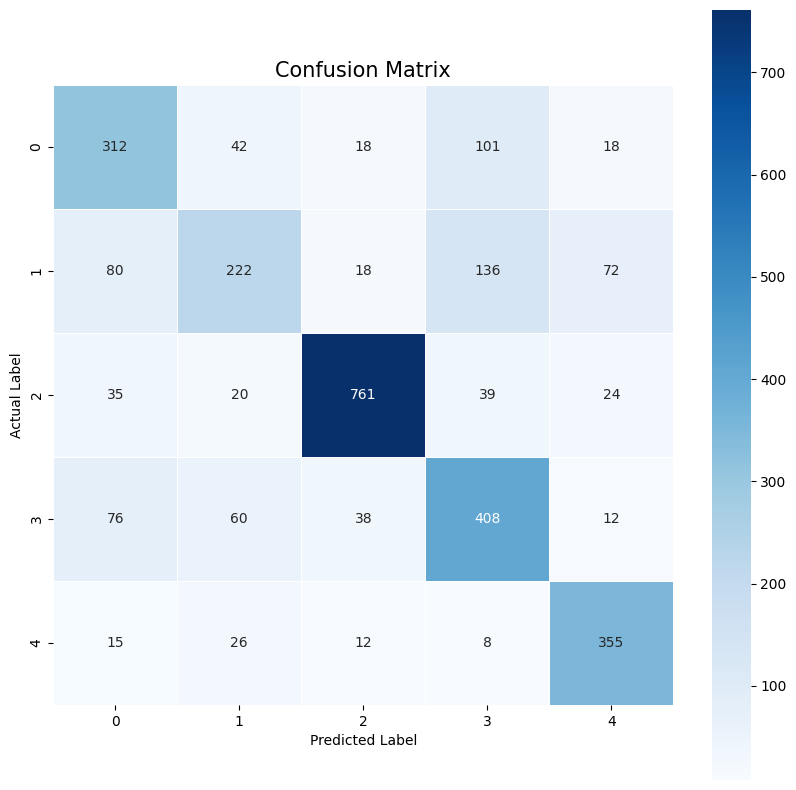

In [24]:
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred)